# Molecular Isotopic Distributions Part 1: Enumerating Isotopic Placements

Elements can have several [isotopes](https://en.wikipedia.org/wiki/Isotope), which have the same number of protons and neutrons but different numbers of neutrons. Because a neutron has a mass of approximately 1 amu (atomic mass unit), different isotopes of an element appear at different masses in a mass spectrum as measured by a mass spectrometer.

Different elements have different isotopes and different natural abundances, meaning the percent of each isotope that is found in nature. For example, [carbon has two stable isotopes](https://en.wikipedia.org/wiki/Isotopes_of_carbon), <sup>12</sup>C with 98.9% natural abundance and <sup>13</sup>C with 1.06% natural abundance. As another example, [oxygen has three stable isotopes](https://en.wikipedia.org/wiki/Isotopes_of_oxygen), <sup>16</sup>O with 99.8% natural abundance, <sup>17</sup>O with 0.0380% natural abundance, and <sup>18</sup>O with 0.205% natural abundance. The distribution of isotopes thus forms a fingerprint for an element. 

When atoms combine into molecules, the mass distributions get richer. For example, in the diatomic molecule chlorine Cl<sub>2</sub>, which has two chlorine atoms, there are three possible molecular isotopes:

In [17]:
%%capture
%!pip install rdkit
%!pip install mendeleev

In [18]:
from collections import defaultdict
import hashlib
import json

from IPython.display import display, Markdown
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl

import mendeleev
from rdkit import Chem
from rdkit.Chem import Descriptors

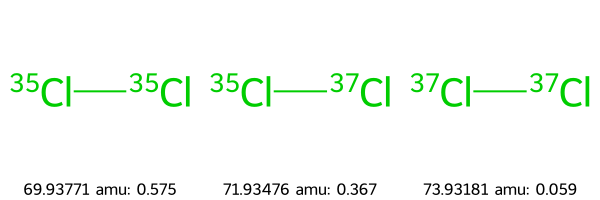

In [19]:
chlorine_smls = ["[35Cl][35Cl]", "[35Cl][37Cl]", "[37Cl][37Cl]"]
chlorine_mols = [Chem.MolFromSmiles(sml) for sml in chlorine_smls]
chlorine_masses = [Descriptors.ExactMolWt(mol) for mol in chlorine_mols]
chlorine_abundances = [0.574564, 0.366872, 0.058564]
legends = [f"{mass:.5f} amu: {abundance:.3f}" for mass, abundance in zip(chlorine_masses, chlorine_abundances)]
legends
Chem.Draw.MolsToGridImage(chlorine_mols, legends=legends)

The molecule <sup>35</sup>Cl<sup>37</sup>Cl in the middle, with mixed isotopes, represents two possible placements of the isotopes: it is equivalent to <sup>37</sup>Cl<sup>35</sup>Cl because the order of the chlorine atoms is not significant due to symmetry. 

The code to generate such molecules, masses, abundance, and images will be given in this blog post and the next.

In part 1, I use the naive method of creating a molecule for each possible arrangement of isotopes ([permutation](https://en.wikipedia.org/wiki/Permutation)) of a molecule. I hazily recalled that I could
- enumerate the [combinations](https://en.wikipedia.org/wiki/Combination), where the order of the isotopes over the atoms in a molecule is disregarded, and 
- calculate the permutations in each combination using the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) to calculate the number of arrangements of a given number of each isotope ([isotopomer](https://en.wikipedia.org/wiki/Isotopomer)),

but I decided to first try the approach that was easier to code. However, I learned that became computationally infeasible for large molecules: for example, assigning isotopes for all permutations of napthlene, C<sub>10</sub>H<sub>8</sub> (SMILES of `c1c2ccccc2ccc1`), where each element has two isotopes and there are thus [2<sup>18</sup> = 262,144 permutations](https://en.wikipedia.org/wiki/Power_of_two#Table_of_values), took about 170 seconds. So I used the combinations approach in part 2.

## Set up

We use [sulfur dichloride, a "cherry-red liquid"](https://en.wikipedia.org/wiki/Sulfur_dichloride) (inorganic chemists have colorful molecules!), as the example molecule.

In [73]:
sml = "ClSCl"
# sml = "c1c2ccccc2ccc1"

Because RDKit excludes hydrogen atoms by default, but we want to assign isotopes to any hydrogen atoms that might be in our molecule, we tell RDKit to add hydrogens.

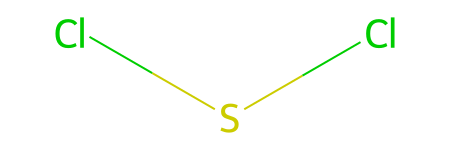

In [74]:
mol = Chem.AddHs(Chem.MolFromSmiles(sml))
mol

Next we define a `MolecularIsotope` class to store an RDKit molecule along with an abundance. (If we didn't need to store the abundance, we could simply use RDKit mol and extract the exact mass.)

In [75]:
class MolecularIsotope():
  """Store a molecule's isotopic properties."""
  def __init__(
      self,
      sml: str,
      abundance: float = None):
    self.sml = sml
    self.abundance = abundance
    try:
      self.mol = Chem.AddHs(Chem.MolFromSmiles(sml))
    except:
      self.mol = Chem.AddHs(Chem.MolFromSmiles(sml, sanitize=False))
    self.mass = Descriptors.ExactMolWt(self.mol)
    
  def update(self):
    self.mass = Descriptors.ExactMolWt(self.mol)
    self.canon_sml = Chem.MolToSmiles(mol)

Next we create a utility function to get the set of elements in a molecule.

In [76]:
def element_set(molecule: Chem.Mol):
    """Get the set of elements in an RDKit molecule
    For example, ethanol (SMILES CCO, formula C2H5OH)
    returns {'C', 'O', 'H'}.

    :param molecule: An RDKit molecule
    :returns: A set of strings.
    """
    # Check that there is a valid molecule
    if molecule:
      # Add hydrogen atoms--RDKit excludes them by default
      molecule_with_Hs = Chem.AddHs(molecule)
      atom_symbols = set(atom.GetSymbol() for atom in molecule_with_Hs.GetAtoms())
      return atom_symbols

In [77]:
set_of_elements = element_set(mol)
set_of_elements

{'Cl', 'S'}

Now we can create a data structure to hold the isotopic abundances of each element in our molecule. The structure is a dictionary where the key is the element symbol and the value is a nested list of [mass number, abundance] pairs. We get the abundances from the [Mendeleev](https://pypi.org/project/mendeleev/) package, filtering to those isotopes whose abundance is not `None` to remove unstable isotopes, trace isotopes, etc.

In [78]:
isotopes = {}
for element_symbol in set_of_elements:
  element_isotopes = mendeleev.element(element_symbol).isotopes
  occurring_isotopes = [[isotope.mass_number, isotope.abundance/100] for isotope in element_isotopes if isotope.abundance != None]
  isotopes[element_symbol] = occurring_isotopes
print(isotopes)

{'S': [[32, 0.9484999999999999], [33, 0.0076300000000000005], [34, 0.04365], [36, 0.00015800000000000002]], 'Cl': [[35, 0.758], [37, 0.242]]}


In this approach, the isotope of each atom in the molecule will be set individually, so we'll create an n-dimensional NumPy array where n is the number of atoms. The length of each dimension is the number of isotopes for that atom. Our initial array is empty, and we'll populate it with molecular isotope objects and set the isotopes next.

In [79]:
# Build iterable of number of isotopes by atom index
isotopes_by_atom_index = ()
for atom_index, atom in enumerate(mol.GetAtoms()):
  atom_symbol = atom.GetSymbol()
  isotopes_by_atom_index += (len(isotopes[atom_symbol]),)

# Create the empty numpy ndarray with the shape of the number of isotopes for each atom
mol_isotopes = np.empty(isotopes_by_atom_index, dtype=object)

## Scale of the problem

To get a sense of the scale of the operation, let's calculate how many permutations ([isotopologues](https://en.wikipedia.org/wiki/Isotopologue)) we'll have to assign isotopes to.

In the NumPy array, there is a dimension for each atom (three) in the molecule, and the length of each dimension is the number of isotopes for the element of that atom (two for each Cl and four for the single S):

In [80]:
mol_isotopes.shape

(2, 4, 2)

We can calculate the number of elements by multiplying together the size of each dimensions:

In [81]:
size = 1
for dim_size in mol_isotopes.shape:
    size *= dim_size
size

16

or by letting NumPy tell us the array size:

In [82]:
mol_isotopes.size

16

We can verify that these numbers make sense using the formula for the number of permutations:

In [99]:
def permutations_with_repetition(n, r):
    return n**r

where, for a given element, n is the number of isotopes and r is the number of atoms of that element.

Each element's permutations can be calculated separately, then multiplied together to get the total for the molecule. For S, there are four isotopes and one atom, so four permutations:

In [121]:
p_S = permutations_with_repetition(4, 1)
p_S

4

For Cl, there are two isotopes and two atoms, so four permutations:

In [118]:
p_Cl = permutations_with_repetition(2, 2)

So for SCl<sub>2</sub> there are 16 permutations:

In [120]:
p_S * p_Cl

16

## Setting the isotope of each atom in each permutation

Now we come to the key operation: Setting the isotope of each atom in a molecule, for each permutation.

`set_isotopes` assigns isotopes to all elements in a multi-dimensional ndarray by
- recursively traversing down the ndarray until it comes to an individual element, not another (nested) ndarray
- inserting the MolecularIsotope object, including its RDKit molecule and the abundance
- for each atom,
    - assigning the isotope by referring to the `isotopes` array
    - assigning its abundance
    - calculating the overall abundance as the product of each of the atom's abundances
- calling the MolecularIsotope.update() method to set the exact mass

In [101]:
def set_isotopes(arr:np.ndarray, sml: str, current_index: tuple =()):
    # If this is an ndarray, iterate through its elements, recursively calling this function on them
    if isinstance(arr, np.ndarray):
        for i in range(len(arr)):
            arr[i] = set_isotopes(arr=arr[i], current_index=current_index + (i,), sml=sml)
        return arr
    else:
        # For an individual item in the ndarray, create molecule, 
        # set the isotopes of each of its atoms, and calculate abundance
        item = MolecularIsotope(sml=sml)
        mol = item.mol
        abundance = 1
        for atom_index, atom in enumerate(mol.GetAtoms()):
          atom_symbol = atom.GetSymbol()
          isotope_data_to_use = isotopes[atom_symbol][current_index[atom_index]]
          isotope_to_use = isotope_data_to_use[0]
          atom.SetIsotope(isotope_to_use)
          abundance *= isotope_data_to_use[1]
        item.update()
        item.abundance = abundance          
        return item

Let's set the isotope of each atom in the molecule for each permutation.

In [102]:
# Set the isotopes for each atom in each molecule
mol_isotopes = set_isotopes(arr = mol_isotopes, sml = sml, current_index=())

## Aggregating isotopomers

Because we're creating each permutation, we have to aggregate the isotopomers, analogous to matching up <sup>35</sup>Cl<sup>37</sup>Cl and <sup>37</sup>Cl<sup>35</sup>Cl.

It might be tempting to match molecules by mass, but a floating-point value can have some error or uncertainty. In some cases, the mass differences between different species can be quite small (for example less than 0.002 amu if the sum of the [mass numbers](https://en.wikipedia.org/wiki/Mass_number) is the same), so adding a numerical tolerance risks lumping distinct isotopologues together. So it's best to use a non-numerical identifier.

### Determining composition

In this case, we use the composition, which contains isotope labels. In particular, we
- use a nested dictionary where the first level key is the element e.g. Cl, and the second level is the isotope:count, for example 35:2 indicates that <sup>35</sup>Cl appears two times in the molecule
- convert to [JSON](https://en.wikipedia.org/wiki/JSON), sorting the keys to ensure a consistent order
- hash the result using `hash_nested_dict()`, below, to create a single string for comparison.

In [103]:
def composition(
        molecule: Chem.Mol,
        isotopes=False):
    """Get the composition of an RDKit molecule:
    Atomic counts, including hydrogen atoms, and any charge.
    For example, ethanol (SMILES [13C](H)(H)(H)CO, formula C2H6O) returns:
      if isotopes = False (default): {'C': 2, 'O': 1, 'H': 6}.
      if isotopes = True: {'C': {13: 1, 0: 1}, 'O': {0: 1}, 'H': {0: 6}}.

    :param molecule: The RDKit molecule to analyze
    :returns: if isotopes = False (default): a dictionary of element:count entries;
              if isotopes = True: a nested dictionary of element:isotope:count entries.
    """
    # Check that there is a valid molecule
    if molecule:

        # Add hydrogen atoms--RDKit excludes them by default
        molecule = Chem.AddHs(molecule)
        comp = defaultdict(lambda: 0)

        # Get atom counts
        for atom in molecule.GetAtoms():
            element_symbol = atom.GetSymbol()
            # If isotopes not requested, simply count the number of atoms of each element
            if not isotopes:
                comp[element_symbol] += 1
            # If isotopes requested, count the number of each isotope of each element
            else:
                isotope = atom.GetIsotope()
                try:
                    comp[element_symbol][isotope] += 1
                except:
                    comp[element_symbol] = defaultdict(lambda: 0)
                    comp[element_symbol][isotope] += 1
        return comp

As an example composition, we'll calculate it for our original molecule SCl<sub>2</sub>. The isotopes of its atoms are not set, so they have a value of zero by RDKit's convention.

In [104]:
composition(mol, isotopes=True)

defaultdict(<function __main__.composition.<locals>.<lambda>()>,
            {'Cl': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {0: 2}),
             'S': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {0: 1})})

To make it easier to compare isotopic variations, we'll flatten the ndarray (whose dimension count is the number of atoms) using a utility function `flatten_ndarray`.

In [105]:
def flatten_ndarray(arr):
    flat_list = []
    for element in arr:
        if isinstance(element, np.ndarray):
            flat_list.extend(flatten_ndarray(element))
        else:
            flat_list.append(element)
    return flat_list

We then flatten the ndarray and sort it by mass.

In [106]:
mol_isotopes_flat = flatten_ndarray(mol_isotopes)
mol_isotopes_flat.sort(key=lambda x:x.mass)

Here's the composition dictionary for one isotopologue of our molecule:

In [107]:
composition(mol_isotopes_flat[0].mol, isotopes=True)

defaultdict(<function __main__.composition.<locals>.<lambda>()>,
            {'Cl': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {35: 2}),
             'S': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {32: 1})})

To check if two composition dictionaries are the same, we hash the dictionaries to boil all the contents of a dictionary down to a single string.

In [108]:
def hash_nested_dict(d):
    # Convert the nested dictionary to a JSON string with sorted keys
    json_str = json.dumps(d, sort_keys=True)

    # Hash the JSON string using the cryptographic hash function SHA-256
    hash_obj = hashlib.sha256()
    hash_obj.update(json_str.encode())
    return hash_obj.hexdigest()

We use functions from previous posts to [create molecular formulas]({% post_url 2023-10-20-Molecular-Formula-Generation %}) and [present the molecular formulas in a Markdown table](({% post_url 2023-10-28-Display-Molecular-Formulas %})).

In [109]:
def mol_to_formatted_formula(
    mol: Chem.Mol,
    isotopes: bool = False,
) -> dict[str, str]:
    if mol is None:
        return "Invalid molecule"
    comp = composition(mol, isotopes)

    formula = {"markdown": "", "latex": ""}

    if isotopes:
        isotopes_dict = defaultdict(lambda: defaultdict(str))
        subscripts = defaultdict(lambda: defaultdict(int))
        superscripts = defaultdict(list)

        for element, counts in comp.items():
            for isotope, count in counts.items():
                if count > 1:
                    subscripts[element][isotope] = count
                if isotope != 0:
                    superscripts[element].append(isotope)

                isotopes_dict[element][isotope] = 1
            # Sort the element's isotopes from lowest to highest
            superscripts[element].sort()

        last_item_is_subscript = False
        sorted_element_keys = sorted(isotopes_dict.keys())
        for element in sorted_element_keys:
            isotope_count_pairs = isotopes_dict[element]
            # Sort the element's isotopes from lowest to highest
            sorted_isotope_keys = sorted(isotope_count_pairs.keys())
            for isotope in sorted_isotope_keys:
                if element in superscripts:
                    if isotope in superscripts[element]:
                        formula["markdown"] += f"<sup>{isotope}</sup>"

                        # If superscript immediately follows subscript,
                        # add a small amount of horizontal space using an empty group {}
                        # to prevent them from vertically overlapping
                        if last_item_is_subscript:
                            formula["latex"] += "{}"
                        formula["latex"] += "^{ %d}" % isotope
                        last_item_is_subscript = False
                formula["markdown"] += element
                formula["latex"] += element
                last_item_is_subscript = False
                if element in subscripts:
                    if isotope in subscripts[element]:
                        isotope_count = subscripts[element][isotope]
                        formula["markdown"] += f"<sub>{isotope_count}</sub>"
                        formula["latex"] += "_{ %d}" % isotope_count
                    last_item_is_subscript = True
        # Add beginning and ending dollar signs to LaTeX formula
        formula["latex"] = "$" + formula["latex"] + "$"
    else:
        # Handling the case when isotopes is False
        sorted_element_keys = sorted(comp.keys())

        for element in sorted_element_keys:
            count = comp[element]
            formula["markdown"] += element
            formula["latex"] += element
            if count > 1:
                formula["markdown"] += f"<sub>{count}</sub>"
                formula["latex"] += "_{ %d}" % count
        formula["latex"] = "$" + formula["latex"] + "$"

    return formula

In [110]:
def dict_list_to_markdown_table(data, number_rows=False):
    """
    Convert a list of dictionaries into a Markdown table.

    Args:
        data (list): A list of dictionaries, where each dictionary corresponds to a row in the table.
        include_row_numbers (bool): Whether to include a row number column.

    Returns:
        str: The Markdown-formatted table as a string.
    """
    if not data:
        return ""

    # Extract column headers from the keys of the first dictionary
    headers = data[0].keys()

    # If include_row_numbers is True, add the "Row #" column
    if number_rows:
        headers = ["#"] + list(headers)

    # Create the table headers
    table = "| " + " | ".join(headers) + " |\n"

    # Create the title divider line
    table += "|"
    for _ in headers:
        table += " --- |"
    table += "\n"

    # Create the table body
    for i, row in enumerate(data):
        if number_rows:
            row_data = [i + 1] + [row.get(header, "") for header in headers[1:]]
        else:
            row_data = [row.get(header, "") for header in headers]

        table += "| " + " | ".join(map(str, row_data)) + " |\n"

    return table


### Putting isotopomers in a dataframe

Now we prepare the data to put into a Polars dataframe. We use Polars because it's easy to aggregate based on matching a value such as composition, and very fast. We extract all properties of the MolecularIsotope, most importantly its abundance. We use `hash_nested_dict()` to prepare the string for comparison for aggregation of isotopomers.

In [111]:
data_dict_list = []
for mol_isotope in mol_isotopes_flat:
    mol_isotope.update()
    data_dict = {prop: getattr(mol_isotope, prop) for prop in vars(mol_isotope).keys()}
    data_dict["mol_isotope"] = mol_isotope
    composition_dict = composition(mol_isotope.mol, isotopes=True)
    hashed_composition_dict = hash_nested_dict(composition_dict)
    data_dict["composition_hash"] = str(hashed_composition_dict)
    data_dict_list.append(data_dict)
df = pl.DataFrame(data_dict_list).select(["mass", "abundance", "composition_hash", "mol"])
df = df.with_columns(
    pl.col("mol").map_elements(lambda x: mol_to_formatted_formula(x, isotopes=True)["markdown"]).alias("formula")
)

df_display = df.select(["mass", "formula", "abundance", "composition_hash"]).sort("mass")

Markdown(
    dict_list_to_markdown_table(
        df_display.rows(named=True),
        number_rows=True,
        )
    )

| # | mass | formula | abundance | composition_hash |
| --- | --- | --- | --- | --- |
| 1 | 101.90977636 | <sup>35</sup>Cl<sub>2</sub><sup>32</sup>S | 0.5449739539999999 | 58b343d486a33b5af66af84258a805aaf19df8b9f6279836a373e2c650ad26a4 |
| 2 | 102.90916411999999 | <sup>35</sup>Cl<sub>2</sub><sup>33</sup>S | 0.00438392332 | 5003158917865e69ae25cd83608f6b6c90bf72b5ee0a0ec2ef922c0b2c9aceae |
| 3 | 103.90557225999999 | <sup>35</sup>Cl<sub>2</sub><sup>34</sup>S | 0.025079718600000002 | e558fc61ef18a5650f1c98ab256cd479af332e576da13e473da3e4e97a12a07a |
| 4 | 103.90682627 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>32</sup>S | 0.17398904599999998 | 444f93bbf68bd8975511aaaf45c4be7d154b7a3e41981e452590409bbe703aa4 |
| 5 | 103.90682627 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>32</sup>S | 0.17398904599999998 | 444f93bbf68bd8975511aaaf45c4be7d154b7a3e41981e452590409bbe703aa4 |
| 6 | 104.90621402999999 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>33</sup>S | 0.0013996166800000001 | 88a81501d027e6b3919ac9343f1b9ddb6c2422b2a0e2926a85dca933fed0a1b1 |
| 7 | 104.90621403 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>33</sup>S | 0.0013996166800000001 | 88a81501d027e6b3919ac9343f1b9ddb6c2422b2a0e2926a85dca933fed0a1b1 |
| 8 | 105.90262216999999 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>34</sup>S | 0.0080069814 | 64ff7f3b937033a6db02ef0985823fe636bba3ce5a9c65f459967815a0c70bd6 |
| 9 | 105.90262217 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>34</sup>S | 0.0080069814 | 64ff7f3b937033a6db02ef0985823fe636bba3ce5a9c65f459967815a0c70bd6 |
| 10 | 105.90387618 | <sup>37</sup>Cl<sub>2</sub><sup>32</sup>S | 0.05554795399999999 | 2846a5aed0b61cb6e6c1bde01b2051da891b5c06290115bcff811d5d04435247 |
| 11 | 105.90478612 | <sup>35</sup>Cl<sub>2</sub><sup>36</sup>S | 9.078111200000001e-05 | 35d4df87f08f6ec8b521d6f545787b659991b496b227a03b94e4ff8157a66bd8 |
| 12 | 106.90326394 | <sup>37</sup>Cl<sub>2</sub><sup>33</sup>S | 0.00044684332 | 1c5cefe1901b9c7f439341aa00b449b1d198e13afbb534bee49de13d0ddf77af |
| 13 | 107.89967208 | <sup>37</sup>Cl<sub>2</sub><sup>34</sup>S | 0.0025563186 | a130fb6a86bc81832b58683b416af62f0c16c1ddd4030dfdabb5650d34281525 |
| 14 | 107.90183603 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>36</sup>S | 2.8982888000000004e-05 | fee991b6b30e80e33e2e3bcf8432db6d0a7882770361bd2c3a34e344ceceee99 |
| 15 | 107.90183603 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>36</sup>S | 2.8982888000000004e-05 | fee991b6b30e80e33e2e3bcf8432db6d0a7882770361bd2c3a34e344ceceee99 |
| 16 | 109.89888594 | <sup>37</sup>Cl<sub>2</sub><sup>36</sup>S | 9.253112e-06 | 65289ce387b1115696a2b72164a4c940e3fa1c8218a35fa89eb702edd6d3d1c5 |


The table confirms our earlier calculation that are a total of 16 permutations. Again, the number of permutations is the product of the number of isotopes over each atom. In this case there are three atoms, and each of the two Cl atoms has two isotopes, while the one S atom has four isotopes, so 2 * 2 * 4 = 16.

### Aggregating rows in a dataframe

The following aggregation expressions tell Polars to sum over abundance, and take the first value for other columns (besides abundance, which we're aggregating on). This is easier and faster than writing Python code to aggregate isotopomers.

In [112]:
# Set up aggregation expressions
agg_exprs = [
    pl.sum("abundance").alias("abundance")
] + [
    pl.col(col).first().alias(col)
    for col in df.columns
    if col not in ("composition_hash", "abundance")
]

# Aggregate rows
agg_df = df.group_by("composition_hash").agg(agg_exprs)

# Compute formulas to display in Markdown table and on graph
agg_df = agg_df.with_columns(
    pl.col("mol").map_elements(lambda x: mol_to_formatted_formula(x, isotopes=True)["markdown"]).alias("formula"),
    pl.col("mol").map_elements(lambda x: mol_to_formatted_formula(x, isotopes=True)["latex"]).alias("formula_latex"),
)

# Choose rows to display in Markdown table
agg_df_display = agg_df.select(["mass", "formula", "abundance"]).sort("mass")

# Create Markdown table
table = dict_list_to_markdown_table(
    agg_df_display.rows(named=True),
    number_rows=True)

# Display Markdown table
Markdown(table)

| # | mass | formula | abundance |
| --- | --- | --- | --- |
| 1 | 101.90977636 | <sup>35</sup>Cl<sub>2</sub><sup>32</sup>S | 0.5449739539999999 |
| 2 | 102.90916411999999 | <sup>35</sup>Cl<sub>2</sub><sup>33</sup>S | 0.00438392332 |
| 3 | 103.90557225999999 | <sup>35</sup>Cl<sub>2</sub><sup>34</sup>S | 0.025079718600000002 |
| 4 | 103.90682627 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>32</sup>S | 0.34797809199999996 |
| 5 | 104.90621402999999 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>33</sup>S | 0.0027992333600000002 |
| 6 | 105.90262216999999 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>34</sup>S | 0.0160139628 |
| 7 | 105.90387618 | <sup>37</sup>Cl<sub>2</sub><sup>32</sup>S | 0.05554795399999999 |
| 8 | 105.90478612 | <sup>35</sup>Cl<sub>2</sub><sup>36</sup>S | 9.078111200000001e-05 |
| 9 | 106.90326394 | <sup>37</sup>Cl<sub>2</sub><sup>33</sup>S | 0.00044684332 |
| 10 | 107.89967208 | <sup>37</sup>Cl<sub>2</sub><sup>34</sup>S | 0.0025563186 |
| 11 | 107.90183603 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>36</sup>S | 5.796577600000001e-05 |
| 12 | 109.89888594 | <sup>37</sup>Cl<sub>2</sub><sup>36</sup>S | 9.253112e-06 |


Compared to 16 permutations, the aggregated result has 12 distinct isotopomers (combinations). We'll understand why in the next blog post.

### Checking our abundances

To verify that we calculated and aggregated abundances correctly, we check that the sum of abundances of the isotopomers is 1. (It might be very slightly different depending on the isotope data, numerical precision of operations, etc.)

In [113]:
mol_isotopes_agg_abundances = agg_df["abundance"].to_list()
abundance_sum = sum(mol_isotopes_agg_abundances)
print(abundance_sum)

0.9999379999999999


## Plot abundance vs. mass results

For the graph, to prevent a forest of short lines and colliding labels due to the be many isotopomers with very low abundance, we might want to limit the plot to a cutoff level of abundance.

In [114]:
cutoff = 0.05
agg_df_cutoff = agg_df.filter(pl.col("abundance") > cutoff)

# Format as Markdown table
df_display_cutoff = agg_df_cutoff.select(["formula", "mass", "abundance"]).sort("mass")
table_cutoff = dict_list_to_markdown_table(
    df_display_cutoff.rows(named=True),
    number_rows=True)
Markdown(table_cutoff)

| # | formula | mass | abundance |
| --- | --- | --- | --- |
| 1 | <sup>35</sup>Cl<sub>2</sub><sup>32</sup>S | 101.90977636 | 0.5449739539999999 |
| 2 | <sup>35</sup>Cl<sup>37</sup>Cl<sup>32</sup>S | 103.90682627 | 0.34797809199999996 |
| 3 | <sup>37</sup>Cl<sub>2</sub><sup>32</sup>S | 105.90387618 | 0.05554795399999999 |


Now we can plot the isotopomers above that cutoff level of abundance.

/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


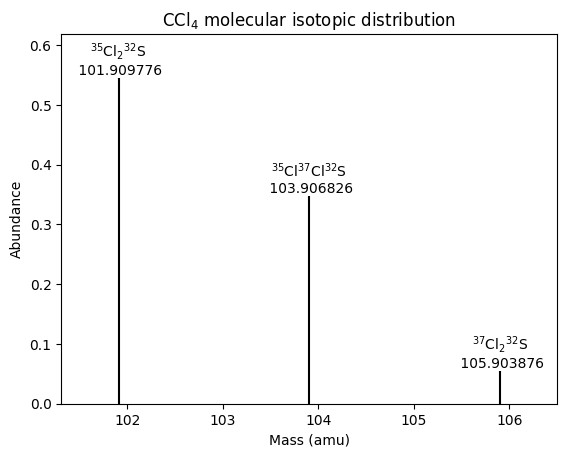

In [115]:
# Create the scatter plot using Seaborn; don't use markers because we'll plot lines instead
sns.scatterplot(x='mass', y='abundance', data=agg_df_cutoff, marker='')

plt.xlabel('Mass (amu)')
plt.ylabel('Abundance')

formula = "CCl_{4}"
# Use C-style string formatting with the % operator to avoid conflicts with using braces for both LaTeX and {}.format()
title = r"${\rm %s}$ molecular isotopic distribution" % formula
plt.title(title)

# Adjust x-axis limits to allow more space on the left and right for labels
xrange = max(agg_df_cutoff['mass']) - min(agg_df_cutoff['mass'])
xpad = xrange * 0.15
plt.xlim(min(agg_df_cutoff['mass']) - xpad, max(agg_df_cutoff['mass']) + xpad)

# Adjust y-axis limits to start at zero and allow more space on the top for labels
yrange = max(agg_df_cutoff['abundance']) - min(agg_df_cutoff['abundance'])
ypad = yrange * 0.15
plt.ylim(0, max(agg_df_cutoff['abundance']) + ypad)

# Iterate through the rows (data points)
for index, (mass, abundance, formula) in enumerate(zip(agg_df_cutoff['mass'], agg_df_cutoff['abundance'], agg_df_cutoff['formula_latex'])):
    # Add vertical lines from each data point to the x-axis
    plt.vlines(x=mass, ymin=0, ymax=abundance, colors='black')

    # Label the data points by mass
    label = r"${\rm %s}$ %s %s" % (formula.strip("$"), "\n", round(mass,6))
    plt.text(
        x=mass, 
        y=abundance, 
        s=label, 
        ha='center',
        va='bottom')

plt.show()

## Conclusion

That's it for this approach. Again, creating a molecule for each permutation is computationally expensive, so in part 2 I'll share a more sophisticated and tractable approach using combinations.

*Acknowledgement: I thank my late father [Robert Monat](https://www.arnmortuary.com/obituary/Robert-Monat) for teaching me about combinations vs. permutations.*